1. Theodore Hsiao, Contribution: 100%

2. Solo Project :)

# Predicting Breast Cancer Survival
### Spring 2024 Data Science Project
### Author: Theodore Hsiao

# Introduction

Breast cancer is the most prevalent cancer type diagnosed in the U.S, with over 300,000 predicted cases in 2024 alone (NCI). It is defined as an abnormal growth originating from the breast tissue and is typically associated with malfunction of the BRCA1 or BRCA2 genes. Breast cancer is typically linked to risk factors such as family history, age, smoking/drinking, and is more common in woman than men. However, expressing these risk factors alone does not guarantee the development of breast cancer, and the lack of risk factors does not guarantee immunity to breast cancer. The goal of this project is use data science techniques to better understand the role of these risk factors on breast cancer survival and to potentially uncover any previously overlooked indicators in order to improve breast cancer diagnosis. 

This tutorial is broken up into 6 parts as follows:
1. Introduction
2. Data Curation
3. Exploratory Data Analysis
4. Primary Analysis
5. Visualization
6. Insights and Conclusions

# Data Curation

To study breast cancer prognosis we will be using a dataset procured from Kaggle. 

The dataset is originally from the NCI SEER database and contains 4024 labled entries (survival/death) with features such as age, race, and tumor differentiation. This set will be used to better understand how to accurately predict breast cancer prognosis. 

Link to dataset:
1. [NCI SEER](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer)

Let's start by importing the necessary packages and reading the data into a pandas dataframe.

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from scipy.stats import f_oneway
from scipy.stats import tukey_hsd
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import ensemble
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from imblearn.over_sampling import RandomOverSampler

### Loading in Datasets

In [2]:
df_prognosis = pd.read_csv('final_project_dataset_2.csv')

df_prognosis

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


# Exploratory Data Analysis

### Data Preprocessing - Prognosis

Before we can start applying statistical analysis and machine learning methods, we must make sure that our data is "clean." Clean just means that the data is accurate and that there are no missing or duplicate entries. 

In [3]:
#removing duplicates or missing entries
df_prognosis = df_prognosis.drop_duplicates()
df_prognosis = df_prognosis.dropna()

Another important step of preprocessing is to ensure that we transform categorical variables into numerical variables so that the features can be used in subsequent analysis. In addition, if there are features that are essentially telling us the same thing, we want to eliminate any extra ones to reduce dimensionality. This is important because high dimensionality can lead to overfitting, which reduces the ability of our models to generalize well to new data. 

The following code will be dropping, mapping, and performing one-hot encoding on some features to make sure that the dataset is ready for use.

### Tumor Size (T1, T2, T3, T4): 

Tumors are classified according to the American Joint Commitee on Cancer (AJCC) 6th Edition. The first classification is on primary tumor size, where T4 > T3 > T2 > T1. This information is already included in the dataset through the tumor size feature, so this feature will be dropped to reduce the number of dimensions. 

In [4]:
#The feature includes a space at the end
df_prognosis = df_prognosis.drop(columns = ['T Stage '])

### Number of Lymph Node Metastases (N1, N2, N3): 

The second classification is similar to the tumor size classification above since the number of lymph node metastases increases with the number following 'N' such that N3 > N2 > N1. This information is already included in the dataset through the regional node features, so this feature will be dropped to reduce the number of dimensions.

In [5]:
df_prognosis = df_prognosis.drop(columns = ['N Stage'])

### Breast Adjusted AJCC 6th Stage: 

Breast Adjusted AJCC 6th Stage is a combination of the TNM staging system. Loosely speaking it is an overall grade as to the severity of the cancer. Since this dataset already includes information on T and N stage, the key information that this variable can provide is M0 (no body metastases) / M1 (body metastases). Any subtype of stage III and under is classified as M0, and any subtype of stage IV is classified as M1. Since none of the patients exhibit stage IV cancer, this variable does not provide any new information and will be dropped from the dataset since preserving it will only increase dimensionality. 

In [6]:
#how many of each type there are 
df_prognosis['6th Stage'].value_counts()

IIA     1304
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: 6th Stage, dtype: int64

In [7]:
df_prognosis = df_prognosis.drop(columns = ['6th Stage'])

### Differentiation / Grade: 

Differentiation refers to how similar the tumor cells look compared to how healthy cells look. Poorly/undifferentiated cells do not display characteristics similar to healthy cells and are generally more agressive, while well differentiated tumors are similar to healthy cells and spreads much slower. 

NCI classifies differentiation into 5 stages: \
Grade X: undetermined \
Grade 1: Well differentiated \
Grade 2: Moderately differentiated \
Grade 3: Poorly differentiated \
Grade 4: Undifferentiated

Since a feature for tumor grade already exists and matches the NCI differentiation/grade classification, this feature will be dropped to reduce dimensionality. 

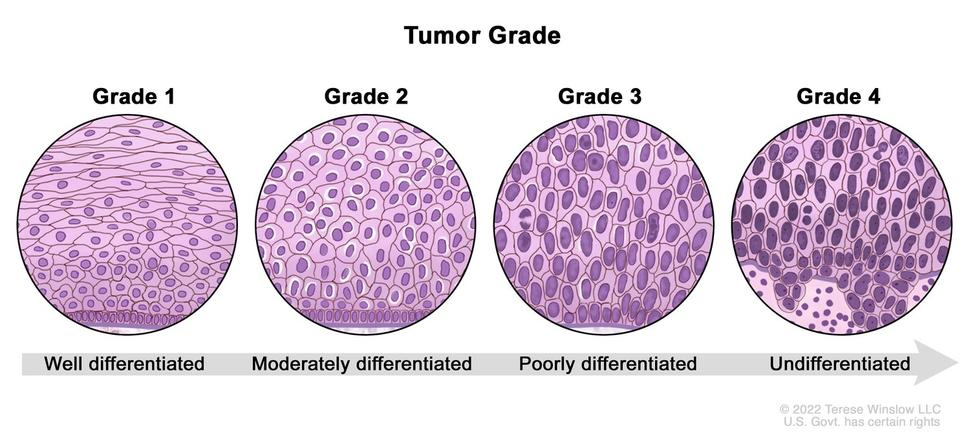

In [8]:
Image(filename='tumor grade.jpeg') 

Figure Retrieved From: [NCI](https://www.cancer.gov/about-cancer/diagnosis-staging/diagnosis/tumor-grade)

In [9]:
df_prognosis = df_prognosis.drop(columns = ['differentiate'])

Grade IV is documented as 'anaplastic; Grade IV' and will be mapped to 4 for consistency.

In [10]:
df_prognosis['Grade'] = df_prognosis['Grade'].map({'1':1, '2':2, '3':3,' anaplastic; Grade IV': 4})

### Estrogen and Progesterone Status: 

All cells express hormone receptors and tumor cells are no different. Estrogen and Progesterone receptors are important because they receive Estrogen and Progesterone signals which tells the cell to grow. If a breast cancer cell expresses either of these receptors, these hormone levels can be reduced in the body which will slow the progression of the tumor. Thus, being estrogen and/or progesterone receptor positive increases the number of treatment options and improves the overall prognosis. 

To modify these columns for analysis, positive will be mapped to 1 and negative will be mapped to 0.

In [11]:
df_prognosis['Estrogen Status'] = df_prognosis['Estrogen Status'].map({'Positive' : 1, 'Negative': 0})
df_prognosis['Progesterone Status'] = df_prognosis['Progesterone Status'].map({'Positive' : 1, 'Negative': 0})

### A Stage

A Stage is classified as regional or distant where regional means that and metastases are local and distant means that the cancer has spread to distant parts of the body. Distant will be mapped to 1 while regional will be mapped to 0.

In [12]:
df_prognosis['A Stage'] = df_prognosis['A Stage'].map({'Distant' : 1, 'Regional': 0})

### Race

Race was recorded as White, Black, and Other. This feature will be one-hot encoded, which means that we will generate new columns for each class and assign 1 or 0 based on the original entries class. 

In [13]:
df_prognosis['Race'].value_counts()

White    3412
Other     320
Black     291
Name: Race, dtype: int64

In [14]:
#race one-hot encoding
df_prognosis = pd.get_dummies(df_prognosis, columns = ['Race'])

### Marital Status

Marital Status is broken up into several categories: married, single, divorced, widowed, and seperated. Each unique category could certainly have an impact on survival, but in order to prevent over-complication and a high dimensionality, single/divorced/widowed/seperated will be combined into one class. This feature will then be mapped such that married is mapped to 1 while single is mapped to 0.

In [15]:
df_prognosis['Marital Status'].value_counts()

Married      2642
Single        615
Divorced      486
Widowed       235
Separated      45
Name: Marital Status, dtype: int64

In [16]:
#combining single/divorced/widowed/seperated, space after single is intentional
df_prognosis['Marital Status'] = df_prognosis['Marital Status'].map({'Married': 'Married', 'Single ': 'Single', 'Divorced': 'Single', 'Widowed': 'Single', 'Separated': 'Single'})

#marital status one-hot encoding
df_prognosis['Marital Status'] = df_prognosis['Marital Status'].map({'Married': 1, 'Single': 0})

### Regional Node Examined / Regional Node Positive

These feature describe the number of lymph nodes nearby the tumor that were examined and whether or not they were cancerous. The fraction of cancerous lymph nodes examined could also be a valuable trait so a new feature will be introduced that shows the percent positive regional nodes. 

In [17]:
#fixing typo in column name
df_prognosis = df_prognosis.rename(columns = {'Reginol Node Positive' : 'Regional Node Positive', 'differentiate' : 'Differentiation'})

#creating new column to show percent positive regional nodes
df_prognosis['Regional Node Percent Positive'] = df_prognosis['Regional Node Positive'] / df_prognosis['Regional Node Examined']

### Status

The final feature that must be modified is status. This feature describes whether or not the patient survived as a categorical variable (Alive or Dead) and must be converted into a numerical feature in preparation for analysis. Alive was chosen to be mapped to 1, and Dead was chosen to be mapped to 0

In [18]:
#changing status from string to categorical to numerical
df_prognosis['Status'] = df_prognosis['Status'].map({'Alive' : 1, 'Dead' : 0})

### Summary Statistics - Prognosis

After all that preprocessing of the data, let's see how our dataframe looks now. 

In [19]:
df_prognosis

,Age,Marital Status,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status,Race_Black,Race_Other,Race_White,Regional Node Percent Positive
0,68,1,3,0,4,1,1,24,1,60,1,0,0,1,0.041667
1,50,1,2,0,35,1,1,14,5,62,1,0,0,1,0.357143
2,58,0,2,0,63,1,1,14,7,75,1,0,0,1,0.500000
3,58,1,3,0,18,1,1,2,1,84,1,0,0,1,0.500000
4,47,1,3,0,41,1,1,3,1,50,1,0,0,1,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,1,2,0,9,1,1,1,1,49,1,0,1,0,1.000000
4020,56,0,2,0,46,1,1,14,8,69,1,0,0,1,0.571429
4021,68,1,2,0,22,1,0,11,3,69,1,0,0,1,0.272727
4022,58,0,2,0,44,1,1,11,1,72,1,1,0,0,0.090909


In [20]:
df_prognosis.shape

(4023, 15)

In [21]:
df_prognosis.count()

Age                               4023
Marital Status                    4023
Grade                             4023
A Stage                           4023
Tumor Size                        4023
Estrogen Status                   4023
Progesterone Status               4023
Regional Node Examined            4023
Regional Node Positive            4023
Survival Months                   4023
Status                            4023
Race_Black                        4023
Race_Other                        4023
Race_White                        4023
Regional Node Percent Positive    4023
dtype: int64

In [22]:
df_prognosis.nunique()

Age                                40
Marital Status                      2
Grade                               4
A Stage                             2
Tumor Size                        110
Estrogen Status                     2
Progesterone Status                 2
Regional Node Examined             54
Regional Node Positive             38
Survival Months                   107
Status                              2
Race_Black                          2
Race_Other                          2
Race_White                          2
Regional Node Percent Positive    299
dtype: int64

In [23]:
df_prognosis.describe()

,Age,Marital Status,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status,Race_Black,Race_Other,Race_White,Regional Node Percent Positive
count,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000
mean,53.969923,0.656724,2.150634,0.022869,30.477007,0.933134,0.826498,14.358439,4.158837,71.301765,0.846880,0.072334,0.079543,0.848123,0.326521
std,8.963118,0.474862,0.638309,0.149503,21.121253,0.249820,0.378728,8.100241,5.109724,22.923009,0.360147,0.259072,0.270617,0.358946,0.287037
min,30.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.020408
25%,47.000000,0.000000,2.000000,0.000000,16.000000,1.000000,1.000000,9.000000,1.000000,56.000000,1.000000,0.000000,0.000000,1.000000,0.103448
50%,54.000000,1.000000,2.000000,0.000000,25.000000,1.000000,1.000000,14.000000,2.000000,73.000000,1.000000,0.000000,0.000000,1.000000,0.214286
75%,61.000000,1.000000,3.000000,0.000000,38.000000,1.000000,1.000000,19.000000,5.000000,90.000000,1.000000,0.000000,0.000000,1.000000,0.500000
max,69.000000,1.000000,4.000000,1.000000,140.000000,1.000000,1.000000,61.000000,46.000000,107.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualizing Data

Fantastic! Now our data is ready to use, let's first look at how our data is distributed. 

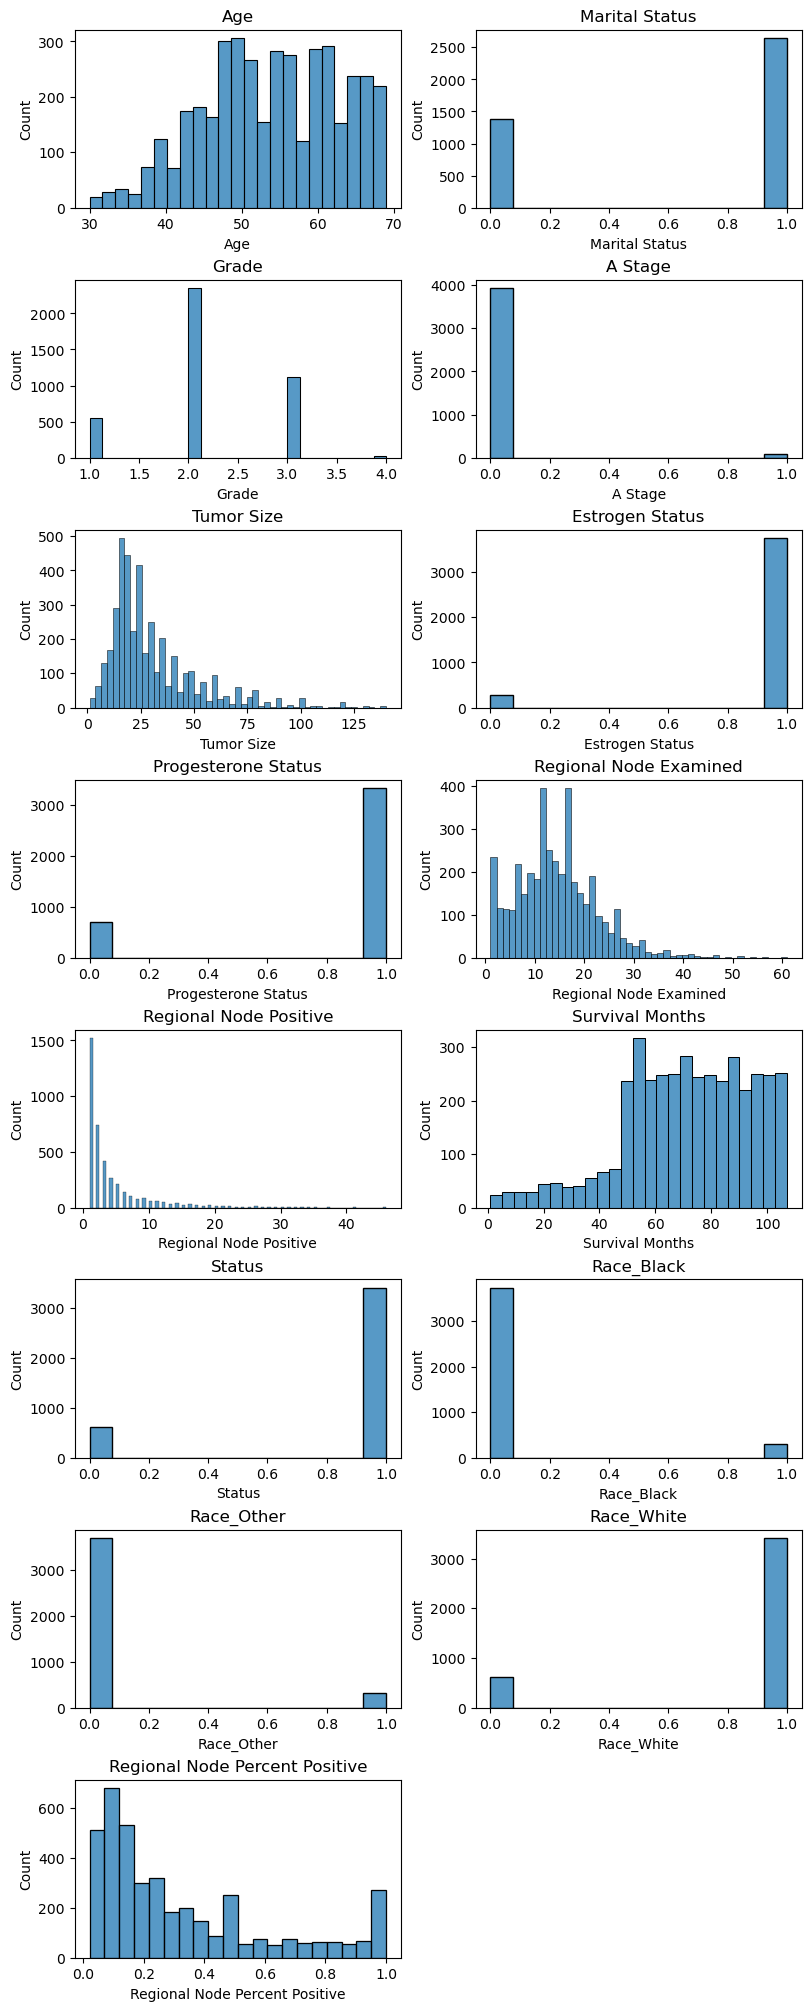

In [24]:
fig, axes = plt.subplots(nrows = 8, ncols = 2, layout = 'constrained', figsize = (8, 20))

row = 0
col = 0

for feature in df_prognosis.columns:
    axes[row, col].set_title(feature)
    sns.histplot(ax = axes[row, col], data=df_prognosis, x=feature)

    if col == 1:
        row = row + 1
        col = 0
    else:
        col = col + 1
        
fig.delaxes(axes[7][1])

Based on our plots we let's take note of a few characteristics. 

The features for age and survival months are both left skewed while the features for tumor size and regional nodes are right skewed. The population is on the older side with a mean age of 54 years and there is primarily Caucasian. There also exists a higher frequency of married vs. single individuals.

Cancer stages are primarily on the lower end, whereas cancer grade is centered around a grade of 2. There are very few patients with distant metastases. A high frequency of patients were positive for both estrogen and progesterone receptor expression. 

Looking at this information, it is important to acknowledge that this dataset is not very diverse and therefore our results may not be as robust when applied to a non-biased population. 

### Outlier Analysis

Another factor that can impact the ability of a machine learning model is the presence of outliers. Outliers can heavily skew the model and cause it to overfit. These high complexity models are generally poor at predicting new data, so we must make note of outliers within the data. Let's accomplish this through the use of boxplots. Note that any points appearing on the plots are outliers. 

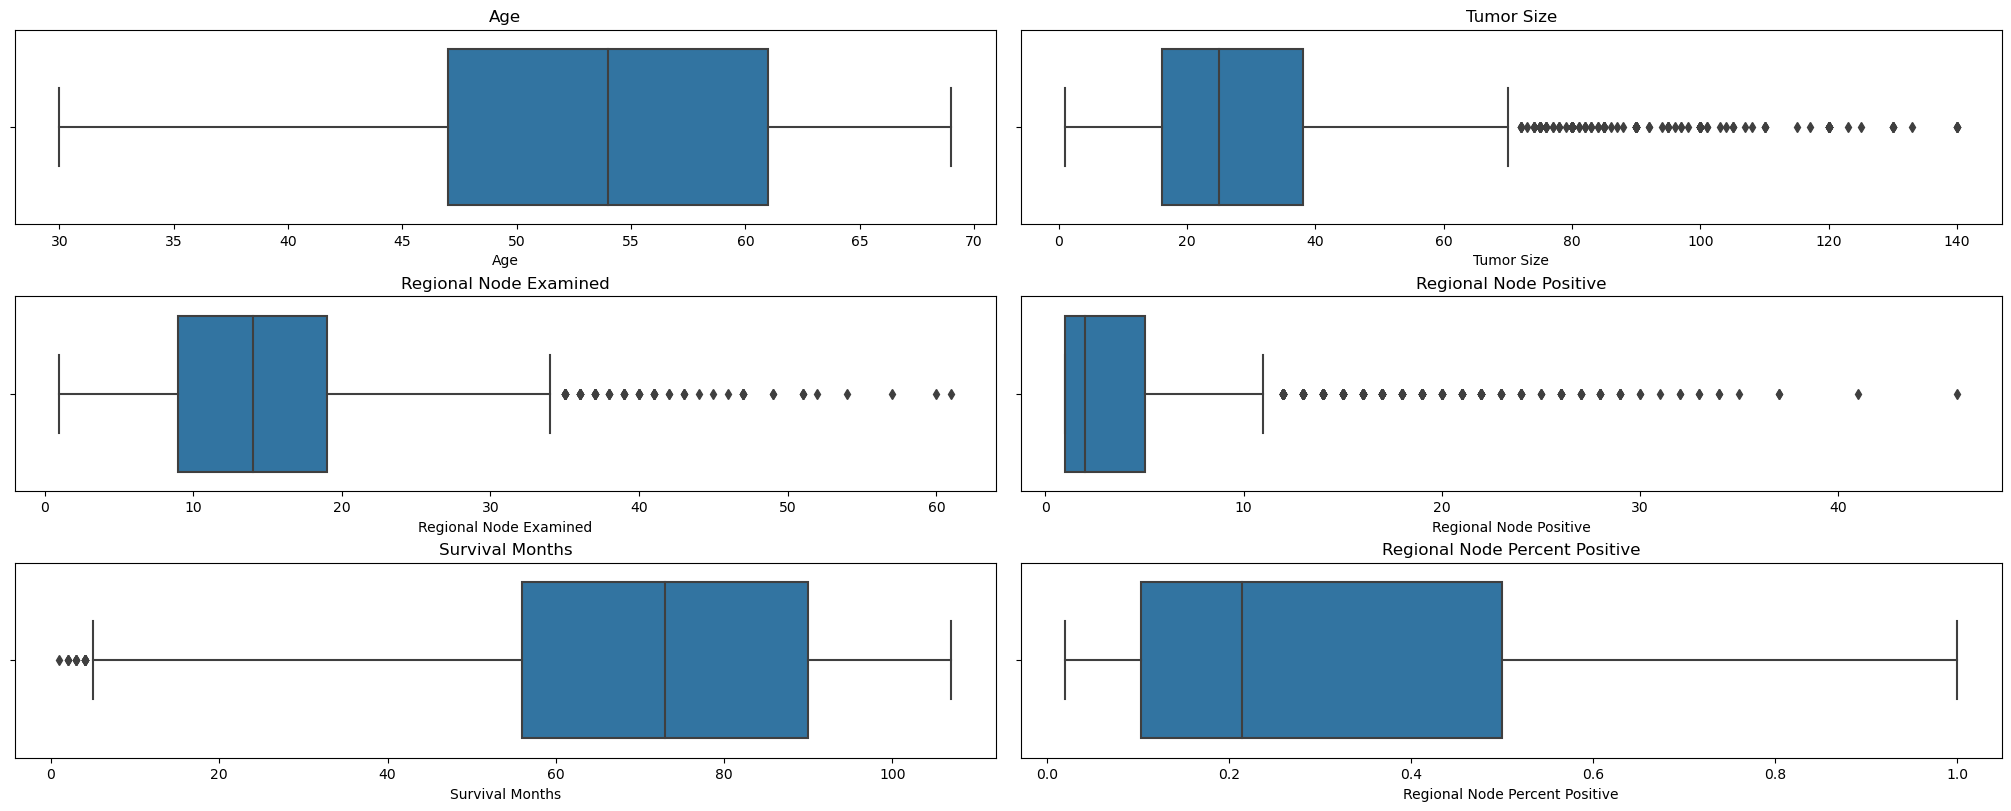

In [25]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, layout = 'constrained', figsize = (20, 8))

row = 0
col = 0

for feature in ['Age', 'Tumor Size', 'Regional Node Examined', 'Regional Node Positive', \
                'Survival Months', 'Regional Node Percent Positive']:
    axes[row, col].set_title(feature)
    sns.boxplot(ax = axes[row, col], data=df_prognosis, x=feature, orient = 'h')

    if col == 1:
        row = row + 1
        col = 0
    else:
        col = col + 1

It is clear from the above boxplots that a significant number of outliers exists for tumor size, regional node examined, regional node positive, and survival months. Given that the data was directly taken from the NCI it is unlikely that any of the outliers are due to mistakes in data entry or data collection. Cancer is known to be highly variable so it is to be expected that outliers will exist, so for this reason outliers will **not** be removed from the dataset. 

Now that we've gotten a good feel for our data, let's apply some statistical methods to try and find relationship between our features and our target variable. 

### Pearson Correlation Coefficients

A quick way to uncover relationships between variables is through a heatmap. A heatmap is essentially a plot that shows the correlation between every pair of variables, where 1 means a strong positive correlation, -1 means a strong negative correlation, and 0 means no correlation. 

<Axes: >

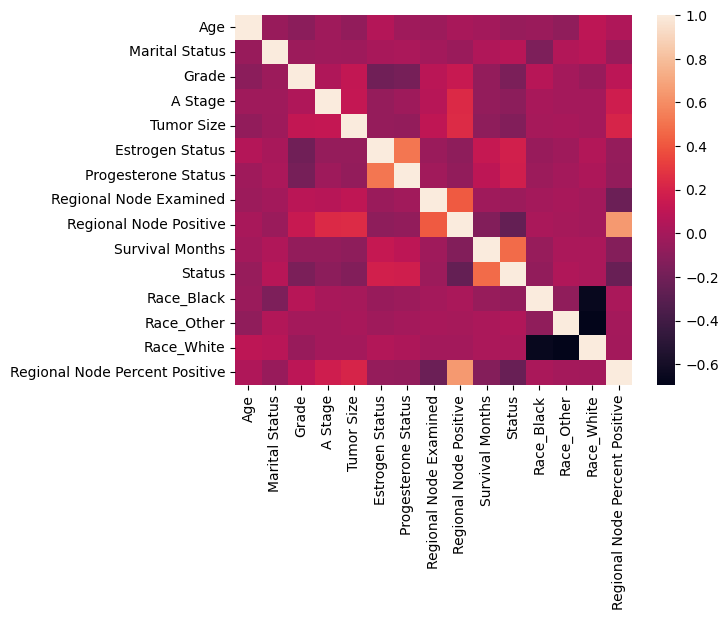

In [26]:
sns.heatmap(df_prognosis.corr())

The primary column we are concerned with here is Status. Based on the heatmap, Estrogen Status and Progesterone Status have the highest correlation with Status (other than survival months). There is also a high correlation between the two hormone receptors.

Let's take a closer look. 

### Correlation between Estrogen Status and Status

In [27]:
#The correlation is expected to be high based on the heatmap
coeff = df_prognosis['Estrogen Status'].corr(df_prognosis['Status'])

print("Pearson Coefficient for Estrogen Status and Status is %f" %(coeff))

Pearson Coefficient for Estrogen Status and Status is 0.184628


### Correlation between Progesterone Status and Status

In [28]:
#The correlation is expected to be low based on the heatmap.
coeff = df_prognosis['Progesterone Status'].corr(df_prognosis['Status'])

print("Pearson Coefficient for Progesterone Status and Status is %f" %(coeff))

Pearson Coefficient for Progesterone Status and Status is 0.177039


As expected, Progesterone Status and Estrogen Status have a relatively strong correlation with Status. The next step here is to determine whether or not there is statistical signifiance. 

### T Tests

Out of the low associativities mentioned above, expression of progesterone and estrogen receptors was the most strongly correlated with survival. To see whether or not there is a significant difference in survival between those with and without the hormone receptors, let's apply some T testing. 

### Progesterone

*H0:* There is no significant difference in the survival of those who are progesterone receptor positive vs. negative.

*HA:* There is a significant difference in the survival of those who are progesterone receptor positive vs. negative.

alpha = 0.05

In [29]:
#progesterone

progesterone_positive = df_prognosis[df_prognosis['Progesterone Status'] == 1]['Status']
progesterone_negative = df_prognosis[df_prognosis['Progesterone Status'] == 0]['Status']

stat, p = ttest_ind(progesterone_positive, progesterone_negative)

print('The associated p-value is %.2E which is less than the alpha of 0.05 so we reject the null in favor of the alternative' %p)


The associated p-value is 1.10E-29 which is less than the alpha of 0.05 so we reject the null in favor of the alternative


Text(0.5, 1.0, 'Survival vs. Progesterone Status')

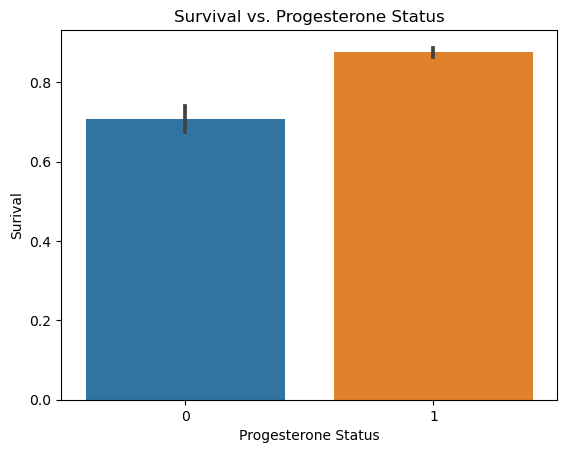

In [30]:
sns.barplot(data = df_prognosis, x = 'Progesterone Status', y = 'Status');

plt.ylabel('Surival')
plt.title('Survival vs. Progesterone Status')

### Estrogen

*H0:* There is no significant difference in the survival of those who are estrogen receptor positive vs. negative.

*HA:* There is a significant difference in the survival of those who are estrogen receptor positive vs. negative.

alpha = 0.05

In [31]:
#estrogen

estrogen_positive = df_prognosis[df_prognosis['Estrogen Status'] == 1]['Status']
estrogen_negative = df_prognosis[df_prognosis['Estrogen Status'] == 0]['Status']

stat, p = ttest_ind(estrogen_positive, estrogen_negative)

print('The associated p-value is %.2E which is less than the alpha of 0.05 so we reject the null in favor of the alternative' %p)



The associated p-value is 3.53E-32 which is less than the alpha of 0.05 so we reject the null in favor of the alternative


Text(0.5, 1.0, 'Survival vs. Estrogen Status')

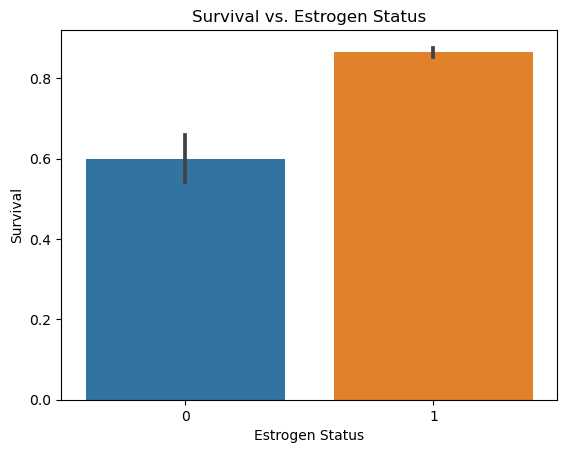

In [32]:
sns.barplot(data = df_prognosis, x = 'Estrogen Status', y = 'Status');

plt.ylabel('Survival')
plt.title('Survival vs. Estrogen Status')

From this analysis, it's clear that estrogen status and progesterone status have a significant impact on survival. Let's keep this in mind for when we are building our machine learning model. 

What about the other features? We can also take a look at race since breast cancer incidence has been shown to vary among individuals of different races ([SEER](https://seer.cancer.gov/statistics-network/explorer/application.html?site=55&data_type=1&graph_type=2&compareBy=sex&chk_sex_3=3&chk_sex_2=2&rate_type=2&race=8&age_range=1&stage=101&advopt_precision=1&advopt_show_ci=on&hdn_view=0&advopt_show_apc=on&advopt_display=2)). Let's take a look and see if our dataset matches this claim through an ANOVA test. ANOVA tests are for analysis of variance and tell us if there is statistical significance between more than 2 groups.

### ANOVA Test

Does Race Impact Survival? \
H0: There is no significant difference in survival for each race \
HA: There is a significant difference in survival in at least one of the groups \
alpha = 0.05

Creating Population Sets

In [33]:
white_population = df_prognosis[df_prognosis['Race_White'] == 1]['Status']
black_population = df_prognosis[df_prognosis['Race_Black'] == 1]['Status']
unlisted_population = df_prognosis[df_prognosis['Race_Other'] == 1]['Status']

Hypothesis Testing

In [34]:
F, p = f_oneway(white_population, black_population, unlisted_population)

print("The p-value is: %f" %(p))

The p-value is: 0.000001


Based on the hypothesis testing it is clear that there is a statistically significant difference in at least one of the groups so a post-hoc test must be performed.

In [35]:
post_hoc = tukey_hsd(white_population, black_population, unlisted_population)

print(post_hoc)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.101     0.000     0.050     0.153
 (0 - 2)     -0.046     0.070    -0.096     0.003
 (1 - 0)     -0.101     0.000    -0.153    -0.050
 (1 - 2)     -0.148     0.000    -0.216    -0.080
 (2 - 0)      0.046     0.070    -0.003     0.096
 (2 - 1)      0.148     0.000     0.080     0.216



Text(0.5, 1.0, 'Survival vs. Race')

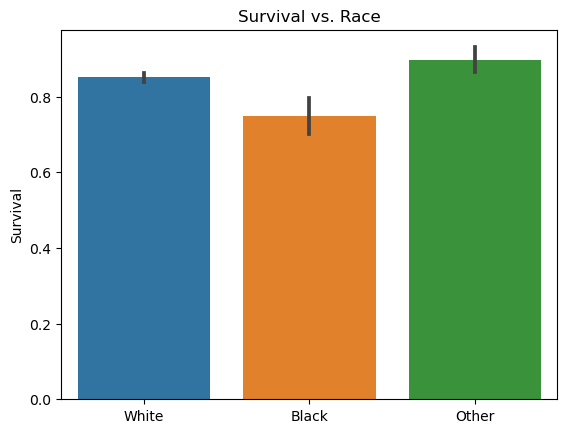

In [36]:
#recombine the one-hot encoded race feature
d = {'White': white_population, 'Black': black_population, 'Other': unlisted_population}
df_temp = pd.DataFrame(d)

sns.barplot(data = df_temp);

plt.ylabel('Survival')
plt.title('Survival vs. Race')

Based on the post-hoc test, there is no significant difference in survival between White and Other (p = 0.07), but there is a significant different between Black and White (p = 0.00) as well as Black and Other (p = 0.00). This is further corroborated in the bar plot that clearly shows that the error bars between White individuals and unlisted individuals do not overlap while the survival rate for Black individuals is significantly lower compared other races. This indicates that race will be an important factor used to predict breast cancer prognosis. 

So moving into our primary analysis, we have a few promising features that could be valuable to building our machine learning model. To summarize, we saw that estrogen and progesterone, along with race, had a significant impact survival. Let's also remember that we chose to keep outliers into the set which may lead to overfitting. If the accuracies of our model when subject to new testing data are too low, we may need to go back and remove that outliers to get a better fit. 

# Primary Analysis

What we are trying to predict is survival, which is a binary variable (either alive or dead). We also know that we have 14 features. For our first approach, let's try and model the data using logistic regression.

### Logistic Regression - Naive Attempt

Logistic Regression is built upon the Linear Regression algorithm with the key change that a sigmoid function is used to generate output. A sigmoid function takes an input and returns 0 or 1 and is the reason why logistic regression is used for classification type problems.

Logistic regression is one of the simpler machine learning algorithms and requires the assumption that the inter-variable relationships are linear. Nonetheless, it's a good first approach. 

Let's start off by separating our data into a features set and a target variable.

In [63]:
#features
X = df_prognosis.drop(columns = 'Status')

#target
y = df_prognosis['Status']

Next we will split the partitioned data into a training set and a testing set. We will also need to standardize the features to ensure that all features have equal weight in predicting the target variable. A random state will be used so that the output will be the same each time the code is run.

In [64]:
#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.2, stratify = y)

#scaling the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

Now we are ready to create the model. We will be using the LogisticRegression model from sklearn. 

In [65]:
#creating the model
model = LogisticRegression()

#fitting the data
model.fit(X_train, y_train)

LogisticRegression()

To see how well our model is fitting to the data, let's look at the accuracy of the model (the probability that the model predicts correctly) for the training set and then the testing set. 

In [66]:
#analysis for training set

#predicting values
y_train_predict = model.predict(X_train)

#accuracy
accuracy = model.score(X_train, y_train_predict)

#displaying results
print('Training Set:')
print('Accuracy =  %.3f' %(accuracy))

Training Set:
Accuracy =  1.000


In [67]:
#analysis for testing set

#predicting values
y_predict = model.predict(X_test)

#accuracy
accuracy = model.score(X_test, y_test)

#cm for later
cm_logistic = confusion_matrix(y_test, y_predict)

#displaying results
print('Testing Set:')
print('Accuracy =  %.3f \n' %(accuracy))

Testing Set:
Accuracy =  0.892 



Hmm... While it's good that the accuracy is high when scored against both sets, the accuracy for the training set is 1, and much higher than that for the testing set. This suggests that overfitting is taking place, i.e. the model is fitting too close to the training set and is not generalizing well. 

One of the best tools to checking for overfitting is cross validation. Cross validation is a technique that breaks up the training data into folds, and iteratively trains and tests the model on each. For each run, one fold will be set aside for testing and the rest will be used for training. This will give us a much better sense at how the model will perform when new data is inputted. 

Since there are much more data entries for alive than dead, we have a class imbalance in our target variable. For our cross validation, let's use a stratified k-fold to preserve the same class proportions in the testing / training splits. 

In [42]:
#k-folds was chosen to be 10 as a generally accepted value
k_folds = 10

#stratified k-fold is used to ensure the proportion of each class remains the same in each sample
skf = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state=25)

acc = cross_val_score(model, X_train, y_train, cv = skf)
print('Accuracy: %.3f +/- %.3f' %(np.mean(acc), np.std(acc)))

Accuracy: 0.894 +/- 0.014


Accuracy is a good first indicator of model fit but loses potency when class imbalance exists in the dataset. Because we are working with class imbalance, additional metrics must be included to get a better idea of the strength of this model.

The following metrics will be added:
- Precision
- Recall
- F1 Score

Precision gives an indication to the amount of false positives and recall gives an indication to the amount of false negatives. F1 score is the harmonic mean between the two. In general, we are trying to maximize each of these scores, but in practice we can generally only choose one to optimize. For this example, we are prioritizing recall since we don't want to miss any potentially fatal cases. 

In [43]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.78      0.41      0.53       123
           1       0.90      0.98      0.94       682

    accuracy                           0.89       805
   macro avg       0.84      0.69      0.74       805
weighted avg       0.88      0.89      0.88       805



In the data preprocessing the feature for dead was mapped to 0 and alive was mapped to 1. Since we are more interested in predicting if the cancer is fatal, we will look at the column for 0. The classification report shows us that the precision is reasonably high (0.78) while the recall is quite low (0.41). This is problematic because when trying to predict cancer prognosis, we are trying to minimize the number of false of negatives. 

### Re-Sampling

To help mitigate this class imbalance issue we can resample the data to produce a more evenly proportioned variable. Here we will use a technique called oversampling, which uses data from the minority class at a higher frequency than the majority class in order to balance the two classes. 

In [44]:
#original class distribution
y.value_counts()

1    3407
0     616
Name: Status, dtype: int64

In [45]:
oversampler = RandomOverSampler(random_state=25)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [46]:
#post oversampler class distribution
y_resampled.value_counts()

1    3407
0    3407
Name: Status, dtype: int64

Fantastic! Now we will perform the same procedure as shown before and we will see if correcting for the class imbalance helps to increase the precision and recall of the model.

In [47]:
#putting everything above into a function
def logistic_analysis(X, y):
    #test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.2, stratify = y)

    #scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    scaler = StandardScaler()
    scaler.fit(X_test)
    X_test = scaler.transform(X_test)

    #creating the model
    model = LogisticRegression()

    #fitting the data
    model.fit(X_train, y_train)

    #analysis for training set

    #predicting values
    y_train_predict = model.predict(X_train)

    #MSE
    mse = mean_squared_error(y_train, y_train_predict)

    #accuracy
    accuracy = model.score(X_train, y_train_predict)

    #displaying results
    print('Training Set:')
    print('MSE = %.3f' %(mse))
    print('Accuracy =  %.3f' %(accuracy))
    
    print('\n')
    
    #analysis for testing set

    #predicting values
    y_predict = model.predict(X_test)

    #MSE
    mse = mean_squared_error(y_test, y_predict)

    #accuracy
    accuracy = model.score(X_test, y_test)

    #displaying results
    print('Testing Set:')
    print('mse = %.3f' %(mse))
    print('Accuracy =  %.3f \n' %(accuracy))

    #k-folds was chosen to be 10 as a generally accepted value
    k_folds = 10

    #stratified k-fold is used to ensure the proportion of each class remains the same in each sample
    skf = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state=25)

    acc = cross_val_score(model, X_train, y_train, cv = skf)
    print('Accuracy: %.3f +/- %.3f' %(np.mean(acc), np.std(acc)))
    
    print(classification_report(y_test, y_predict))
    
    return confusion_matrix(y_test, y_predict)

In [48]:
print('Logistic Regression Using Oversampled Data:\n')
cm_logistic_oversampled = logistic_analysis(X_resampled, y_resampled)

Logistic Regression Using Oversampled Data:

Training Set:
MSE = 0.215
Accuracy =  1.000


Testing Set:
mse = 0.236
Accuracy =  0.764 

Accuracy: 0.784 +/- 0.021
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       682
           1       0.75      0.79      0.77       681

    accuracy                           0.76      1363
   macro avg       0.76      0.76      0.76      1363
weighted avg       0.76      0.76      0.76      1363



Using the oversampled dataset, we see that the accuracy of the model has decreased compared to the original. This is a characteristic trade-off, we lost accuracy in favor of recall. Our goal was to maximize recall though, so overall this model is performing better for how we intended. 

However, even though we lost some accuracy the recall score is still relatively low (0.74). We want our model to have a recall that is as close to 1 as possible. How can we do better though?

### Random Forest Classifier

While using a logistic regression model was a good first attempt, there were a number of shortcomings as highlighted by the above analysis. For example, Logistic Regression is prone to overfitting and can struggle with high dimensional data. While this dataset didn't have more features than data entries, there were still 14 features used to predict the target variable. Looking at the above results, it is clear that overfitting occurred since the accuracy using the training data was perfectly 1, while the accuracy using the testing data was much lower at 0.892 in the original set and 0.764 in the oversampled set. Logistic Regression also assumes a linear relationship between the features and the target variable. It is unlikely that the complexity of cancer prognosis can be modeled using simple linear relationships. 

A better approach is to use a Random Forest Classifier (RFC). An RFC is an ensemble of decision trees that make choices based on the most common output from the group of trees that make up the RFC. RFC's are powerful due to these characteristics, and are less prone to overfitting and are better for high dimensional data when compared to Logistic Regression. For this next section, let's use an RFC. 

In [49]:
#test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.2, stratify = y)

#creating the model
clf = ensemble.RandomForestClassifier(oob_score = True)

#training the model
clf.fit(X_train, y_train)

#predictions
y_predict = clf.predict(X_test)

Some important metrics that can be used to evaluate the performance of the model are out-of-bag score and accuracy score. Loosely speaking, they tell us how good our model is at predicting the target variable (if you want to learn more about how out-of-bag score is calculated, check out the extended readings at the end of the tutorial)

In [50]:
#oob score
oob_score = clf.oob_score_

#accuracy
score = clf.score(X_test, y_test)

#calculating the confusion matix for later
cm_original = confusion_matrix(y_test, y_predict)

#displaying results
print('Out-Of-Bag Score = %.3f' %(oob_score))
print('Accuracy = %.3f' %(score))


Out-Of-Bag Score = 0.903
Accuracy = 0.913


Great! The accuracy score is pretty close to 1 which indicates that the RFC is doing a good job at classification. Let's explore precision/recall/f1-score using a classification report like we did in the previous section. 

In [51]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.87      0.50      0.64       123
           1       0.92      0.99      0.95       682

    accuracy                           0.91       805
   macro avg       0.90      0.75      0.79       805
weighted avg       0.91      0.91      0.90       805



Hmm... The recall score for the class 'Dead' is still low. Let's try and incorporate the oversampled set to train the classifier against more samples where Status is equal to 0. 

In [52]:
#putting everything into a function
def rfc_analysis(X, y):
    #test/train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 25, test_size = 0.2, stratify = y)

    #creating the model
    clf = ensemble.RandomForestClassifier(oob_score = True)

    #training the model
    clf.fit(X_train, y_train)

    #predictions
    y_predict = clf.predict(X_test)
    
    #oob score
    oob_score = clf.oob_score_

    #accuracy
    score = clf.score(X_test, y_test)

    #displaying results
    print('Out-Of-Bag Score = %.3f' %(oob_score))
    print('Accuracy = %.3f' %(score))

    print(classification_report(y_test, y_predict))
    
    #use this for later
    return confusion_matrix(y_test, y_predict)

In [53]:
print('RFC Using Oversampled Data:\n')
cm_oversampled = rfc_analysis(X_resampled, y_resampled)

RFC Using Oversampled Data:

Out-Of-Bag Score = 0.975
Accuracy = 0.970
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       682
           1       0.99      0.95      0.97       681

    accuracy                           0.97      1363
   macro avg       0.97      0.97      0.97      1363
weighted avg       0.97      0.97      0.97      1363



Perfect! We have a both a high precision and a high recall while maintaining a high accuracy. But can we do even better? Random Forest Classifiers use a set of properties called hyperparameters that essentially allow us to fine tune the model. Let's run some cross validation and try to find the best hyperparameters for the model. 

In [54]:
#test train split using resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state = 25, 
                                                    test_size = 0.2, stratify = y_resampled)

#creating a dictionary of hyperparameters to test
hyperparameters = {
    'n_estimators': [50, 100, 150], 
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [5, 50, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

#grid search cross validation to find optimal hyperparameters
clf = ensemble.RandomForestClassifier()
gscv = GridSearchCV(clf, hyperparameters, cv = 5)
gscv.fit(X_train, y_train)

print('Optimal Hyperparameters:')
print(gscv.best_params_)
print('Best Accuracy = %.3f' %(gscv.best_score_))


Optimal Hyperparameters:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy = 0.967


Now that we have the optimal hyperparameters to use, let's build an optimized Random Forest Classifier. 

In [55]:
#test train split using resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state = 25, 
                                                    test_size = 0.2, stratify = y_resampled)

#creating the model
clf = ensemble.RandomForestClassifier(criterion = 'gini', max_features = 'log2', min_samples_leaf = 1,
                                      min_samples_split = 2, n_estimators = 150, oob_score = True)

#training the model
clf.fit(X_train, y_train)

#predictions
y_predict = clf.predict(X_test)
    
#oob score
oob_score = clf.oob_score_

#accuracy
score = clf.score(X_test, y_test)

#cm for later
cm_optimized = confusion_matrix(y_test, y_predict)

#displaying results
print('Out-Of-Bag Score = %.3f' %(oob_score))
print('Accuracy = %.3f' %(score))

print(classification_report(y_test, y_predict))

Out-Of-Bag Score = 0.975
Accuracy = 0.973
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       682
           1       0.99      0.95      0.97       681

    accuracy                           0.97      1363
   macro avg       0.97      0.97      0.97      1363
weighted avg       0.97      0.97      0.97      1363



The performance metrics before and after hypertuning are essentially the same. Looks like the default settings were already near optimal!

# Visualization

Based on the performance metrics we can clearly see that the model is working. What exactly is a random forest classifier doing behind the scenes? Well let's take a look!

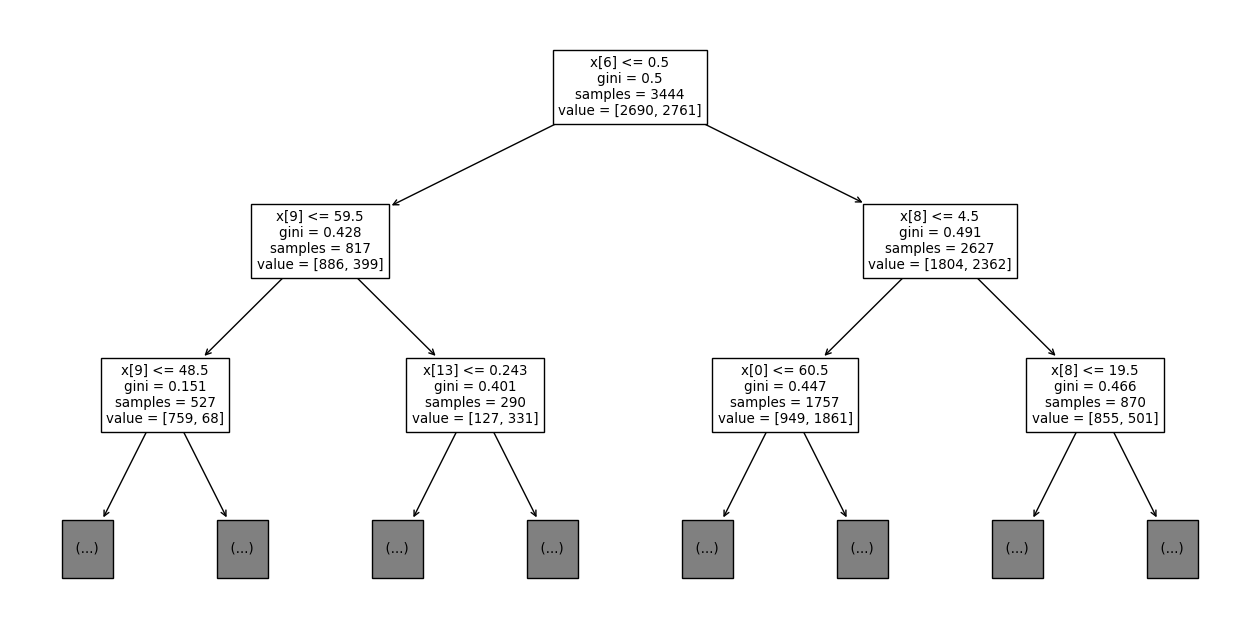

In [56]:
plt.figure(figsize=(16,8))
dt = clf.estimators_[0]
tree.plot_tree(dt, max_depth = 2)
plt.show()

Here we can see the first couple layers of one of the decision trees in the ensemble. The first row of each node tells us the threshold value for the feature that is being used in the decision. Gini is the criterion set when we created the model. Samples is the number of data points that the given node is making a decision on. 

Now let's take a look at the whole thing!

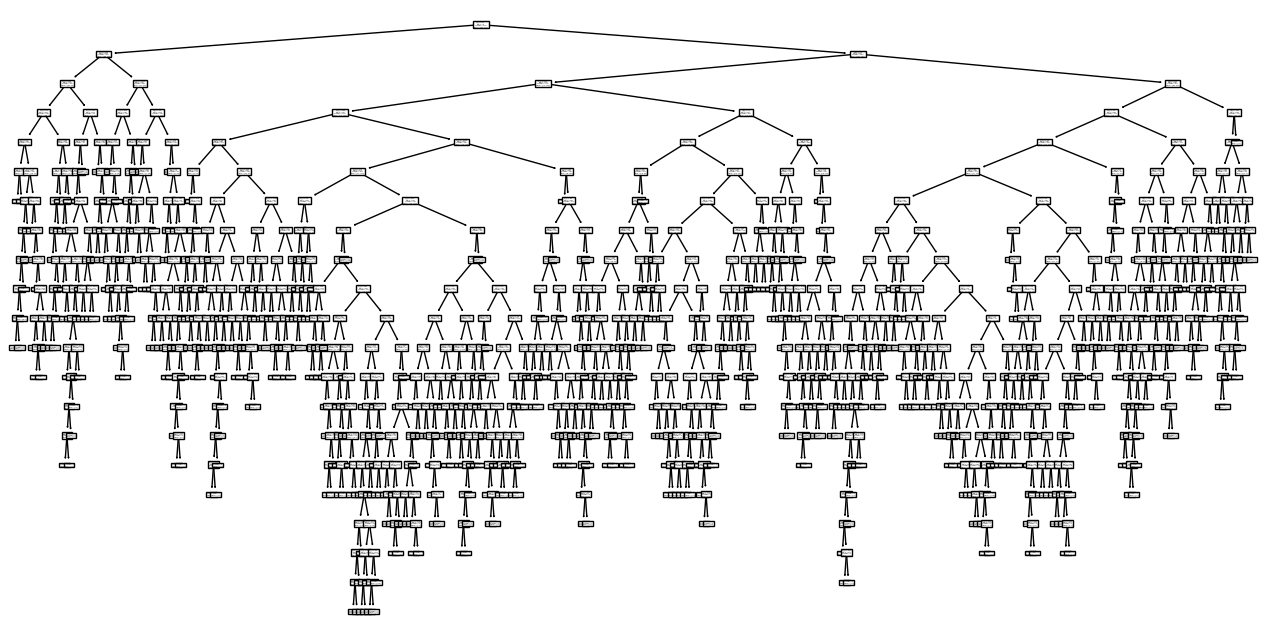

In [57]:
plt.figure(figsize=(16,8))
dt = clf.estimators_[0]
tree.plot_tree(dt)
plt.show()

That's a pretty complex tree! Remember that this is only one of the decision trees that makes up the random forest classifier. When we created the model, we set the number of trees to be 150 in total!

One of the powerful features about sklearn's RandomForestClassifier is the best features property. This allows us to visualize which variables are the most powerful predictors for our target. 

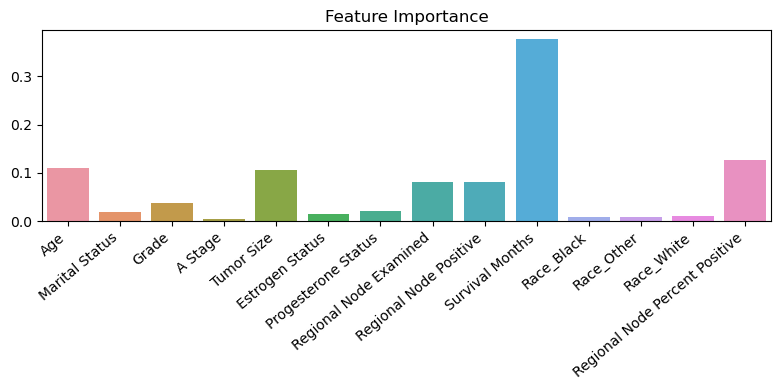

In [58]:
best = clf.feature_importances_
features = X.columns

plt.figure(figsize=(8,4))
ax = sns.barplot(x = features, y = best)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Feature Importance')
plt.tight_layout()

The feature importance plot shows us that age, tumor size, survival months, and regional node percent positive were the best predictors for survival. This isn't exactly what we expected from the statistical analysis, but it's an important insight nonetheless. 

For the problem at hand, a confusion matrix is very valuable metric to measure how well our models are able to predict the data. A confusion matrix shows us the distribution of true positives, true negatives, false positives, and false negatives. Let's compare the confusion matrices from each of the models that we've looked at. 

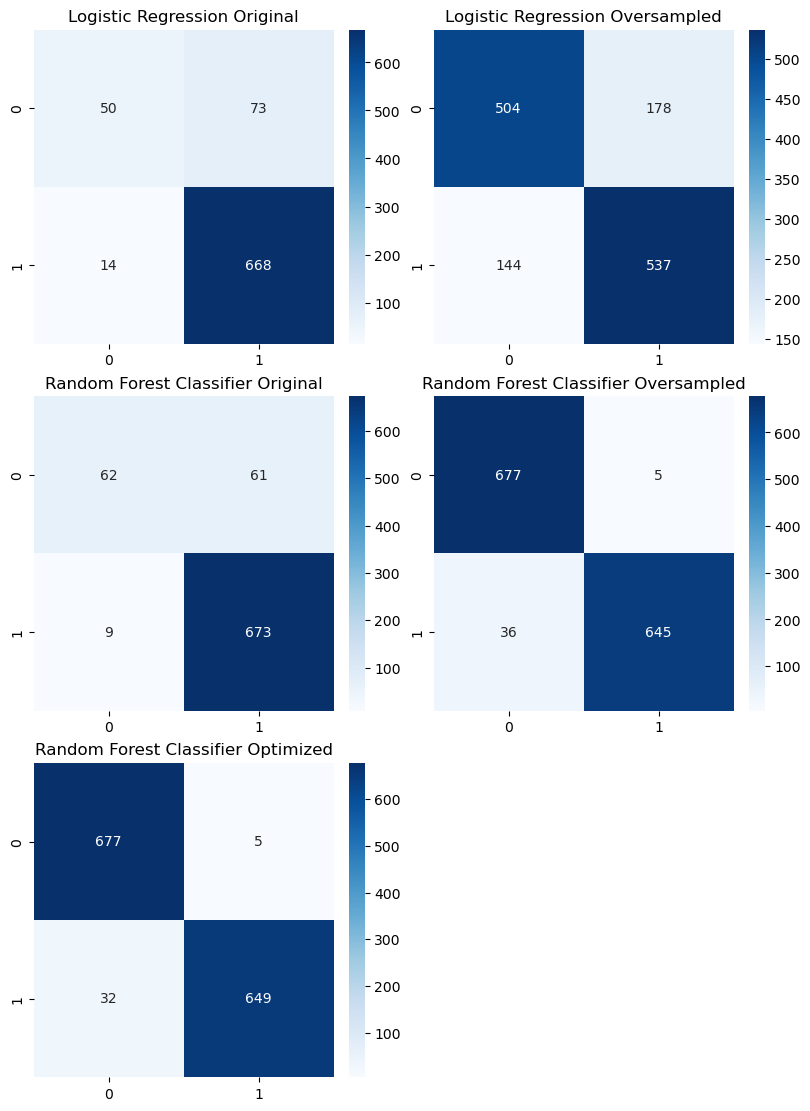

In [59]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, layout = 'constrained', figsize = (8, 11))

axes[0, 0].set_title('Logistic Regression Original')
sns.heatmap(cm_logistic, ax = axes[0, 0], annot = True, fmt='g', cmap = 'Blues')

axes[0, 1].set_title('Logistic Regression Oversampled')
sns.heatmap(cm_logistic_oversampled, ax = axes[0, 1], annot = True, fmt='g', cmap = 'Blues')

axes[1, 0].set_title('Random Forest Classifier Original')
sns.heatmap(cm_original, ax = axes[1, 0], annot = True, fmt='g', cmap = 'Blues')

axes[1, 1].set_title('Random Forest Classifier Oversampled')
sns.heatmap(cm_oversampled, ax = axes[1, 1], annot = True, fmt='g', cmap = 'Blues')

axes[2, 0].set_title('Random Forest Classifier Optimized')
sns.heatmap(cm_optimized, ax = axes[2, 0], annot = True, fmt='g', cmap = 'Blues')

fig.delaxes(axes[2][1])


The upper left and lower right quadrants represent True Positive (TP) and True Negative (TN) respectively, and since we have a much higher number of TP/TN, it's clear that the random forest classifier did a much better job than the logistic regression model. We can also see that the models performed much better on the oversampled data, which is to be expected due to class imbalance in the dataset. It doesn't look like the hyperparameter tuning did much optimizing, I guess the default parameters were already pretty good!

# Insights and Conclusions

Now that we have finished analyzing the data, what new insights can we make about breast cancer prognsosis? Although cancer has been historically difficult to understand due to high variation, the findings presented in this project demonstrate that random forest classifiers are an effective way to predict breast cancer outcome. Furthermore, the most important features are survival months, age, tumor size, and regional node percent positive, suggesting that these key metrics should be closely monitored in patients. 

Regional node percent positive was a new feature calculated from two existing features, regional node examined and regional node positive. In broad terms, the larger the tumor the less likely the chance for survival, which is corroborated by the above feature importance plot. It's interesting that regional node percent positive was the second most important since based on existing information it would expected that net tumor size, or in this the number of regional node positive, would have a higher predictive weight. Furthermore, regional node percent positive is related to how much the cancer is spreading, which should be related to the cancer grade, and yet cancer grade is of surprisingly low relative importance. 

Three features with unexpectedly low importance are estrogen status, progesterone status, and race. With regards to the hormone receptors, it is known that expression of either/both receptors increases the number of treatment options and typically increases life expectancy. In addition, statistical analysis in the data exploration section indicated that there was a significant different in survival rate among those expressing the receptors and those who did not. With regards to race, it is well documented that individuals of different races have different breast cancer incidence rates. Why these features were not utilized well by the classifier is a topic for future study. 

To summarize, we first chose a dataset to study and preprocessed in preparation for statistical analysis and machine learning. After exploring the data, we ran a number of statistical tests and found that race and progesterone/estrogen receptor expression was correlated to survival rate. Finally, after an initial naive attempt to employ a logistic regression model, a random forest classifier was used to model our dataset. As seen in the confusion matrix plots, the random forest classifier heavily out-performed the logistic regression model in all categories. Most importantly, recall was maximized in the random forest classifier, which is the most important metric given that we are trying to minimize false negatives. 

### Extended Readings

#### Breast Cancer
- [Official AJCC Classification](https://www.facs.org/media/tauiudl3/ajcc_6thed_cancer_staging_manual_part1.pdf)
- [Progesterone / Estrogen Receptor](https://www.pennmedicine.org/cancer/types-of-cancer/breast-cancer/types-of-breast-cancer/hormone-positive-breast-cancer#:~:text=Breast%20tumors%20may%20be%20positive,instructing%20the%20cells%20to%20grow.)
- [NCI SEER Statistics](https://seer.cancer.gov/statistics-network/explorer/application.html?site=55&data_type=1&graph_type=2&compareBy=sex&chk_sex_3=3&chk_sex_2=2&rate_type=2&race=1&age_range=1&stage=101&advopt_precision=1&advopt_show_ci=on&hdn_view=0&advopt_show_apc=on&advopt_display=2#resultsRegion0)

#### Logistic Regression vs. Random Forest Classifier
- [GeeksForGeeks](https://www.geeksforgeeks.org/logistic-regression-vs-random-forest-classifier/)

#### Hyperparameter Tuning
- [AWS Tutorial](https://aws.amazon.com/what-is/hyperparameter-tuning/#:~:text=Hyperparameter%20tuning%20allows%20data%20scientists,the%20model%20as%20a%20hyperparameter.)

#### Out of Bag Score
- [GeeksForGeeks](https://www.geeksforgeeks.org/oob-errors-for-random-forests-in-scikit-learn/#:~:text=OOB%20(out%2Dof%2Dbag,models%20such%20as%20random%20forests.)
